<a href="https://colab.research.google.com/github/JonasRiber/Dl_project_HAM10000/blob/main/Ham10000_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
### trying to load
#!pip install deeplake # install the deeplake package

import deeplake # import the deeplake package

ds = deeplake.load('hub://activeloop/ham10000')
ds.summary()

-

Opening dataset in read-only mode as you don't have write permissions.


/

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/ham10000



-

hub://activeloop/ham10000 loaded successfully.

Dataset(path='hub://activeloop/ham10000', read_only=True, tensors=['ages', 'genders', 'image_ids', 'images', 'lesion_categories', 'lesion_ids', 'localizations', 'sources'])

      tensor           htype            shape           dtype  compression
      -------         -------          -------         -------  ------- 
       ages         class_label       (10015, 1)       uint32    None   
      genders       class_label       (10015, 1)       uint32    None   
     image_ids      class_label       (10015, 1)       uint32    None   
      images           image     (10015, 450, 600, 3)   uint8    jpeg   
 lesion_categories  class_label       (10015, 1)       uint32    None   
    lesion_ids      class_label       (10015, 1)       uint32    None   
   localizations    class_label       (10015, 1)       uint32    None   
      sources       class_label       (10015, 1)       uint32    None   


(450, 600, 3)


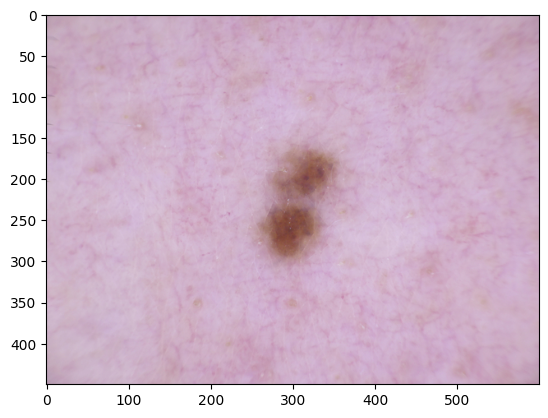

In [27]:
import matplotlib.pyplot as plt
# showcase a single image
image = ds.images[0].numpy()

print(image.shape) # shape of the images
#show the image
plt.imshow(image)
plt.show()


## Base line model


In [44]:
# Check the first few entries of the dataset
for sample in ds[:5]:
    print(sample)

Dataset(path='hub://activeloop/ham10000', read_only=True, index=Index([0]), tensors=['ages', 'genders', 'image_ids', 'images', 'lesion_categories', 'lesion_ids', 'localizations', 'sources'])
Dataset(path='hub://activeloop/ham10000', read_only=True, index=Index([1]), tensors=['ages', 'genders', 'image_ids', 'images', 'lesion_categories', 'lesion_ids', 'localizations', 'sources'])
Dataset(path='hub://activeloop/ham10000', read_only=True, index=Index([2]), tensors=['ages', 'genders', 'image_ids', 'images', 'lesion_categories', 'lesion_ids', 'localizations', 'sources'])
Dataset(path='hub://activeloop/ham10000', read_only=True, index=Index([3]), tensors=['ages', 'genders', 'image_ids', 'images', 'lesion_categories', 'lesion_ids', 'localizations', 'sources'])
Dataset(path='hub://activeloop/ham10000', read_only=True, index=Index([4]), tensors=['ages', 'genders', 'image_ids', 'images', 'lesion_categories', 'lesion_ids', 'localizations', 'sources'])


In [37]:
# Extract images and labels
images = []
labels = []  # Define the labels list

for sample in ds[:5000]:#[:200]just to speed up testing of the code
    images.append(sample['images'].numpy())  # Extract image data
    labels.append(sample['lesion_categories'].numpy())  # Extract lesion categories as labels

In [38]:
import numpy as np
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
# Preprocess images: resize to 128x128 and normalize
images = np.array([img_to_array(array_to_img(image, scale=False).resize((128, 128))) for image in images])
images = images / 255.0  # Normalize pixel values between 0 and 1

# Convert labels to a flat array
labels = np.array(labels).flatten()

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42, stratify=labels)

# One-hot encode labels
y_train = to_categorical(y_train, num_classes=7)
y_test = to_categorical(y_test, num_classes=7)

In [39]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(4000, 128, 128, 3)
(4000, 7)
(1000, 128, 128, 3)
(1000, 7)


In [40]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define the CNN model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation="relu", input_shape=(128, 128, 3)),  # 1st Conv Layer with input shape
    layers.MaxPooling2D((2, 2)),  # 1st MaxPooling Layer
    layers.Conv2D(64, (3, 3), activation="relu"),  # 2nd Conv Layer
    layers.MaxPooling2D((2, 2)),  # 2nd MaxPooling Layer
    layers.Conv2D(64, (3, 3), activation="relu"),  # 3rd Conv Layer
    layers.Flatten(),  # Flatten the 2D output into 1D
    layers.Dense(64, activation="relu"),  # Fully connected layer
    layers.Dense(7, activation="softmax"),  # Output layer with 7 classes (use softmax for multi-class classification)
])

# Compile the model
model.compile(optimizer='adam',  # Adam optimizer
              loss='categorical_crossentropy',  # Cross-entropy loss for multi-class classification
              metrics=['accuracy'])  # We want to track accuracy during training

# Summary of the model
model.summary()

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)  # Train the model on 80% of the training data, use 20% for validation

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)

print(f"Test accuracy: {test_acc}")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)                   │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 28, 28, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 50176)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 64)                  │       3,211,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 7)                   │             455 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,268,103 (12.47 MB)

 Trainable params: 3,268,103 (12.47 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.6144 - loss: 1.3188 - val_accuracy: 0.6850 - val_loss: 0.9785
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.6656 - loss: 0.9616 - val_accuracy: 0.6762 - val_loss: 0.9385
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.6731 - loss: 0.9183 - val_accuracy: 0.6850 - val_loss: 0.8934
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.6886 - loss: 0.8700 - val_accuracy: 0.6762 - val_loss: 0.8884
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.6949 - loss: 0.8331 - val_accuracy: 0.6862 - val_loss: 0.8776
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.7110 - loss: 0.7913 - val_accuracy: 0.7050 - val_loss: 0.8369
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.7198 - loss: 0.7656 - val_accuracy: 0.6913 - val_loss: 0.8554
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.7447 - loss: 0.7188 - val_accu

In [47]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.utils import set_random_seed

set_random_seed(0) # make weight initialization deterministic

model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(266)) # W1*x + b
model.add(Activation('relu')) # ReLU(W1*x + b)
model.add(Dropout(0.5))
model.add(Dense(7)) # W2*x + b
model.add(Activation('softmax')) # softmax(W2*x + b)

In [48]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import Adam

# Initiate Adam optimizer (a variant of Stochastic Gradient Descent)
# (Note: this choice is somewhat arbitrary - see options here: https://keras.io/api/optimizers/)
lr_schedule = ExponentialDecay(
    initial_learning_rate=0.0001,
    decay_steps=10000,
    decay_rate=0.9)
opt = Adam(learning_rate=lr_schedule)

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

# Normalize image data
x_train = X_train.astype('float32')
x_test = X_test.astype('float32')
x_train /= 255.0  # Normalize images to range [0, 1]
x_test /= 255.0


data_augmentation = True
epochs = 10
batch_size = 16

if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    model.fit(datagen.flow(x_train, y_train,
                           batch_size=batch_size),
              epochs=epochs,
              validation_data=(x_test, y_test),
              #workers=4,
              shuffle=True)

Using real-time data augmentation.
Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 33s 93ms/step - accuracy: 0.6453 - loss: 1.3394 - val_accuracy: 0.6630 - val_loss: 1.1478
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 29s 78ms/step - accuracy: 0.6661 - loss: 1.1546 - val_accuracy: 0.6630 - val_loss: 1.1710
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 19s 73ms/step - accuracy: 0.6689 - loss: 1.1621 - val_accuracy: 0.6630 - val_loss: 1.1383
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 23s 80ms/step - accuracy: 0.6564 - loss: 1.1862 - val_accuracy: 0.6630 - val_loss: 1.1219
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 78ms/step - accuracy: 0.6645 - loss: 1.1511 - val_accuracy: 0.6630 - val_loss: 1.1357
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 19s 72ms/step - accuracy: 0.6636 - loss: 1.1198 - val_accuracy: 0.6630 - val_loss: 1.0706
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 18s 72ms/step - accuracy: 0.6540 - loss: 1.1220 - val_accuracy: 0.6630 - val_loss: 1.0123
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 72ms/step -